<a href="https://colab.research.google.com/github/suresh-venkate/Code_Repositories/blob/main/Deep_Learning/Computer_Vision/Image_Classification/Stanford_Cars_Dataset/Stanford_Cars_Dataset_Classification_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Stanford Cars Dataset Classification - PyTorch version

**Author:** Suresh Venkatesan

* Problem statement: Classify images of cars into their respective classes.
* Dataset to be used: Stanford Car Dataset ([Kaggle Link](https://www.kaggle.com/jutrera/stanford-car-dataset-by-classes-folder/download))

# Complete preliminaries

## Connect to Google Drive

In [1]:
### Use this for Google Colab

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Install required libraries

In [2]:
%%capture

!pip install torchmetrics

## Import required libraries

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import datetime
import os
import shutil
import pytz
import math
import requests
import pickle
import gzip
import cv2
%matplotlib inline

from pathlib import Path
from sys import stdout
from IPython.core.debugger import set_trace
from tqdm import tqdm
from torchsummary import summary as ts_summary
import torchmetrics as tm

import torch
from torch import nn
from torch.nn import functional as F
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch import optim as optim
from torch.utils.data import DataLoader, random_split
from torch.utils.tensorboard import SummaryWriter

from sklearn.metrics import confusion_matrix

# Ignore the warnings
import warnings
warnings.filterwarnings("ignore")

%load_ext tensorboard

# from torchvision.transforms import Lambda, Compose

## Define directory paths

In [4]:
# Define base path for TensorBoard Logs directory
tb_logs_base_path = "/content/drive/MyDrive/AI_ML_Folder/Colab_Directory/Model_Outputs/Stanford_Cars_Dataset/TB_Logs/"
os.makedirs(tb_logs_base_path, exist_ok = True) # Don't raise any exception if directory exists
# Define base path for storing all outputs related to model / training
out_base_path = "/content/drive/MyDrive/AI_ML_Folder/Colab_Directory/Model_Outputs/Stanford_Cars_Dataset/Training_Outputs/"
os.makedirs(out_base_path, exist_ok = True) # Don't raise any exception if directory exists
# Define dataset path
dataset_path = "/content/drive/MyDrive/AI_ML_Folder/Colab_Directory/Datasets/Image_Datasets/Stanford_Car_Dataset/"
os.makedirs(dataset_path, exist_ok = True) # Don't raise any exception if directory exists

# Function Definitions

## Function: viz_data_from_dset

In [5]:
def viz_data_from_dset(name, dset, img_dtype, mode, num_images, num_cols, col_size, row_size):

  '''
  Function to plot random images from a PyTorch dataset object along with corresponding labels

  Arguments:
    name: Name to print in title (Training_Set, Test_Set etc.)
    dset: PyTorch dataset object
    img_dtype: Data Type of image array. One of 'Int' or 'Float'
    mode: One of 'grayscale' or 'color'
    num_images: Number of images to plot from input array
    num_cols: Number of columns to use for plotting
    col_size: Size of columns to use for plotting
    row_size: Size of rows to use for plotting

  '''

  num_rows = math.ceil(num_images / num_cols) # Number of rows to use for plotting

  fig = plt.figure(figsize = ((num_cols * col_size), (num_rows * row_size)))
  fig.suptitle('Random sample images from ' + name, fontsize = 40)

  # Generate random sample indices
  samp_index = np.random.randint(low = 0, high = len(dset), size = num_images).tolist()
  
  for ind, value in enumerate(samp_index): # Loop through samp_index
    img, label = dset[value]
    img = img.numpy()
    ax = plt.subplot(num_rows, num_cols, (ind + 1))
    if (mode == 'grayscale'):
      ax.imshow(img.squeeze(), cmap = 'gray') # Plot image in grayscale
    elif (mode == 'color'):
      ax.imshow(img.squeeze()) # Plot image in color
    ax.set_title("Class label is %d" %label, fontsize = 25)
    ax.grid(False)  

  plt.show()  

## Function: viz_data_from_array

In [6]:
def viz_data_from_array(name, X, y, X_dtype, mode, num_images, num_cols, col_size, row_size, bm_name = None):

  '''
  Function to plot random images from an input array along with corresponding labels

  Arguments:
    name: Name to print in title (Training_Set, Test_Set etc.)
    X: Image array (should be in (batch, height, width, channel)) format
    y: label array (Raw labels - should not be One-Hot encoded)
    X_dtype: Data Type of image array. One of 'Int' or 'Float'
    mode: One of 'grayscale' or 'color'
    num_images: Number of images to plot from input array
    num_cols: Number of columns to use for plotting
    col_size: Size of columns to use for plotting
    row_size: Size of rows to use for plotting
    bm_name: Name of base model that will be used to undo pre-processing (if required)

  '''

  num_rows = math.ceil(num_images / num_cols) # Number of rows to use for plotting

  fig = plt.figure(figsize = ((num_cols * col_size), (num_rows * row_size)))
  fig.suptitle('Random sample images from ' + name, fontsize = 40)

  # Generate random sample indices
  samp_index = np.random.randint(low = 0, high = X.shape[0], size = num_images).tolist()

  for ind, value in enumerate(samp_index): # Loop through samp_index
    if (X_dtype == 'int'):
      img = (X[value].squeeze()).astype('uint8') # Extract image and force type to uint8
    elif (X_dtype == 'float') :
      if (bm_name == None):
        img = (X[value].squeeze()).astype('float32') # Extract image and force type to float32
      else:
        img = (X[value].squeeze()).astype('float32') # Extract image and force type to float32        
        img = undo_preprocess_data(img, bm_name) # Undo any pre-processing done on image
    label = y[value] # Extract label
    ax = plt.subplot(num_rows, num_cols, (ind + 1))
    if (mode == 'grayscale'):
      ax.imshow(img, cmap = 'gray') # Plot image in grayscale
    elif (mode == 'color'):
      ax.imshow(img) # Plot image in color

    ax.set_title("Class label is %d" %label, fontsize = 25)
    ax.grid(False)  

  plt.show()  

## Function: viz_data_from_df

In [7]:
def viz_data_from_df(name, df, x_col, y_col, img_root_path, img_cons, plot_bbox,\
               num_images, num_cols, col_size, row_size):

  '''
  Function to plot random images from an input array along with corresponding labels

  Arguments:
    name: Name to print in title (Training_Set, Test_Set etc.)
    df: Name of dataframe to read image details from
    x_col: Name of column in dataframe that contains file names
    y_col: Name of column in dataframe that contains the class names
    img_root_path: Root directory path where images are stored
    img_cons: Boolean: True -> All images are assumed to consolidated in img_root_path (no sub-directories).
                       False -> Images are assumed to be present inside sub-directories in img_root_path
                       named with the class name.
    plot_bbox: Boolean: If True, plot bounding-boxes on top of image
                        Should be set to True only if Dataframe has BBOX co-ords                       
    num_images: Number of images to plot from input array
    num_cols: Number of columns to use for plotting
    col_size: Size of columns to use for plotting
    row_size: Size of rows to use for plotting

  '''

  num_rows = math.ceil(num_images / num_cols) # Number of rows to use for plotting

  fig = plt.figure(figsize = ((num_cols * col_size), (num_rows * row_size)))
  fig.suptitle('Random sample images from ' + name, fontsize = 40)

  # Generate random sample indices
  samp_indices = np.random.randint(low = 0, high = df.shape[0], size = num_images).tolist()

  for ind, value in enumerate(samp_indices): # Loop through samp_index
    img_file_name = df.iloc[value][x_col] # Extract file name of image
    img_class = df.iloc[value][y_col] # Extract class of image
    if (img_cons): # img_cons = True -> All images consolidated in img_root_path
      img_file_path = os.path.join(img_root_path, img_file_name) # Obtain full path of image
    else: # img_cons = False -> Each image is present in a sub-directory inside img_root_path
      img_file_path = os.path.join(img_root_path, img_class, img_file_name)
    img = cv2.imread(img_file_path, cv2.IMREAD_COLOR) # Load image using cv2 as a 3-channel RGB image

    if (plot_bbox): # plot_bbox = True => Plot Bounding-Box on top of image
      img_h, img_w = img.shape[0], img.shape[1] # Extract image dimensions
      xmin, ymin, xmax, ymax = df.iloc[value]['xmin'], df.iloc[value]['ymin'],\
                               df.iloc[value]['xmax'], df.iloc[value]['ymax'] # Get ground-truth 
                                                                              # BBOX co-ords
      # Set box_thickness based on image area  
      box_thickness = int(np.ceil(((img_h) * (img_w)) / (100000)))
      # Draw ground-truth BBOX in green
      cv2.rectangle(img, (xmin, ymin), (xmax, ymax), (0, 255, 0), box_thickness)

    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # Convert image to RGB format
    ax = plt.subplot(num_rows, num_cols, (ind + 1)) # Define plotting axes
    ax.imshow(img) # Plot image in color
    ax.set_title(f"{img_class}", fontsize = 20) # Set title
    ax.grid(False)  

  plt.show()  

# Dataset - Import, EDA and pre-process

## Import dataset

In [8]:
# Copy dataset from Google Drive
img_zip_file_name = "archive.zip"
img_zip_file_path = os.path.join(dataset_path, img_zip_file_name)

# Get start time of run and display it
start_time = datetime.datetime.now(pytz.timezone('Asia/Kolkata'))
print("Started dataset copy at %s..." %(start_time.strftime("%H:%M:%S")), end = ' ')
!cp {img_zip_file_path} .

# Unzip dataset file
print("Unzipping dataset...")
!unzip -q archive.zip
# Delete zip file
!rm archive.zip

# Get end time of run and display elapsed time
end_time = datetime.datetime.now(pytz.timezone('Asia/Kolkata'))
elap_time = ((end_time - start_time).total_seconds())/60
print("Completed at %s. Elapsed time = %0.2f minutes." %(end_time.strftime("%H:%M:%S"), elap_time))

Started dataset copy at 09:18:16... Unzipping dataset...
Completed at 09:19:06. Elapsed time = 0.83 minutes.


In [9]:
# Get some basic information about dataset
dataset_path = "/content/" # Re-point dataset_path to local dataset path

# Define paths of files and folders in dataset
names_csv_path = os.path.join(dataset_path, 'names.csv')
anno_train_csv_path = os.path.join(dataset_path, 'anno_train.csv')
anno_test_csv_path = os.path.join(dataset_path, 'anno_test.csv')
train_img_path = os.path.join(dataset_path, 'car_data/car_data/train')
test_img_path = os.path.join(dataset_path, 'car_data/car_data/test')

# Obtain number of folders and images in train and test set paths
train_img_num_fold = len(os.listdir(train_img_path))
test_img_num_fold = len(os.listdir(test_img_path))
num_train_set_images = 0
num_test_set_images = 0
for _, _, files in os.walk(train_img_path):
    num_train_set_images += len(files)
for _, _, files in os.walk(test_img_path):
    num_test_set_images += len(files)

print(f"{train_img_num_fold} folders found in training set images path")
print(f"{test_img_num_fold} folders found in test set images path")
print()
print(f"{num_train_set_images} images found in training set images path")
print(f"{num_test_set_images} images found in test set images path")
print()    

196 folders found in training set images path
196 folders found in test set images path

8144 images found in training set images path
8041 images found in test set images path



## Create label-class dictionary mapping

In [20]:
# Load classes into a dataframe
classes = pd.read_csv(names_csv_path, header = None, names = ['class'])
# Define empty dictionary to store label_class dictionary mapping
label_class_dict = {}
# Iterate through classes DF and update label_class dictionary mapping
for row in classes.iterrows():
    label_class_dict[row[0] + 1] = row[1]['class']

## Add class names to train and test annotation files

In [11]:
df_cols = ['filename', 'xmin', 'ymin', 'xmax', 'ymax', 'label']

# Load train annotation file to dataframe and add class names to df
train_df = pd.read_csv(anno_train_csv_path, header = None, names = df_cols, index_col = False)
for ind, row in train_df.iterrows(): train_df.loc[ind, 'class'] = label_class_dict[row['label']]

# Load test annotation file to dataframe and add class names to df
test_orig_df = pd.read_csv(anno_test_csv_path, header = None, names = df_cols, index_col = False)
for ind, row in test_orig_df.iterrows(): test_orig_df.loc[ind, 'class'] = label_class_dict[row['label']]

display(train_df.head())
print()
display(test_orig_df.head())

filename  xmin  ymin  ...  ymax  label                                class
0  00001.jpg    39   116  ...   375     14                  Audi TTS Coupe 2012
1  00002.jpg    36   116  ...   587      3                  Acura TL Sedan 2012
2  00003.jpg    85   109  ...   381     91           Dodge Dakota Club Cab 2007
3  00004.jpg   621   393  ...  1096    134     Hyundai Sonata Hybrid Sedan 2012
4  00005.jpg    14    36  ...    99    106  Ford F-450 Super Duty Crew Cab 2012

[5 rows x 7 columns]

filename  xmin  ymin  ...  ymax  label                                class
0  00001.jpg    30    52  ...   147    181              Suzuki Aerio Sedan 2007
1  00002.jpg   100    19  ...   203    103  Ferrari 458 Italia Convertible 2012
2  00003.jpg    51   105  ...   659    145                Jeep Patriot SUV 2012
3  00004.jpg    67    84  ...   407    187              Toyota Camry Sedan 2012
4  00005.jpg   140   151  ...   339    185             Tesla Model S Sedan 2012

[5 rows x 7 columns]

## Split test_orig_df into test_df and val_df

In [12]:
num_val_img_per_class = 6 # Number of images per class to use in validation set
class_list = test_orig_df['class'].unique()

# Create place holder for test_df and val_df
val_df = pd.DataFrame(columns = test_orig_df.columns)
test_df = pd.DataFrame(columns = test_orig_df.columns)

for class_val in class_list:
  temp_test_df = test_orig_df[test_orig_df['class'] == class_val]    
  val_df = val_df.append(temp_test_df[0:num_val_img_per_class])
  test_df = test_df.append(temp_test_df[num_val_img_per_class:])

val_img_path = test_img_path

display(test_df.head())
print()
display(val_df.head())

filename xmin ymin xmax ymax label                    class
560   00561.jpg   44   34  426  286   181  Suzuki Aerio Sedan 2007
709   00710.jpg   74  123  560  357   181  Suzuki Aerio Sedan 2007
883   00884.jpg    8    5  630  439   181  Suzuki Aerio Sedan 2007
917   00918.jpg  113   81  632  428   181  Suzuki Aerio Sedan 2007
1171  01172.jpg   19   62  387  288   181  Suzuki Aerio Sedan 2007

filename xmin ymin xmax ymax label                    class
0    00001.jpg   30   52  246  147   181  Suzuki Aerio Sedan 2007
54   00055.jpg   84  169  561  443   181  Suzuki Aerio Sedan 2007
322  00323.jpg   12   31  489  226   181  Suzuki Aerio Sedan 2007
539  00540.jpg    7  121  635  357   181  Suzuki Aerio Sedan 2007
540  00541.jpg    9   42  282  207   181  Suzuki Aerio Sedan 2007

In [13]:
print(f"Number of images in training set is {train_df.shape[0]}")
print(f"Number of images in validation set is {val_df.shape[0]}")
print(f"Number of images in test set is {test_df.shape[0]}")

Number of images in training set is 8144
Number of images in validation set is 1176
Number of images in test set is 6865


## Get class distribution

### Training Set

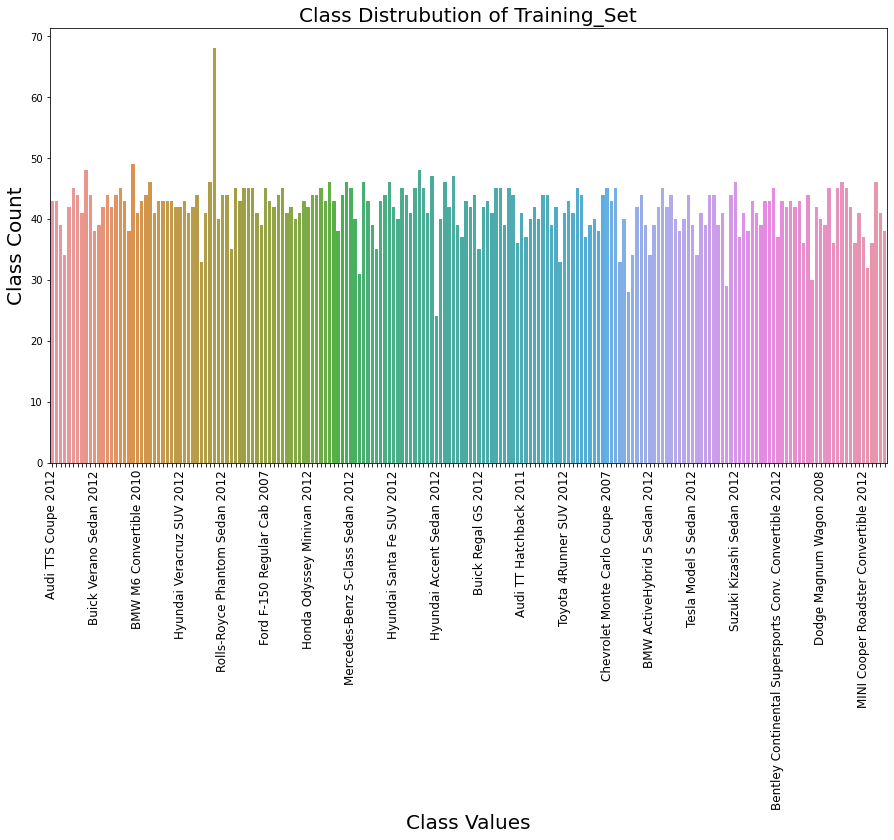

In [14]:
# Class distribution of Training set
plt.figure(figsize = (15, 8))
plot_ = sns.countplot(x = train_df['class'])
plt.title('Class Distrubution of Training_Set', fontsize = 20)
plt.xlabel('Class Values', fontsize = 20)
plt.ylabel('Class Count', fontsize = 20)
plt.xticks(rotation = 90, fontsize = 12)
for ind, label in enumerate(plot_.get_xticklabels()):
  if (ind % 10) == 0:
    label.set_visible(True)
  else:
    label.set_visible(False)
plt.show()

### Validation Set

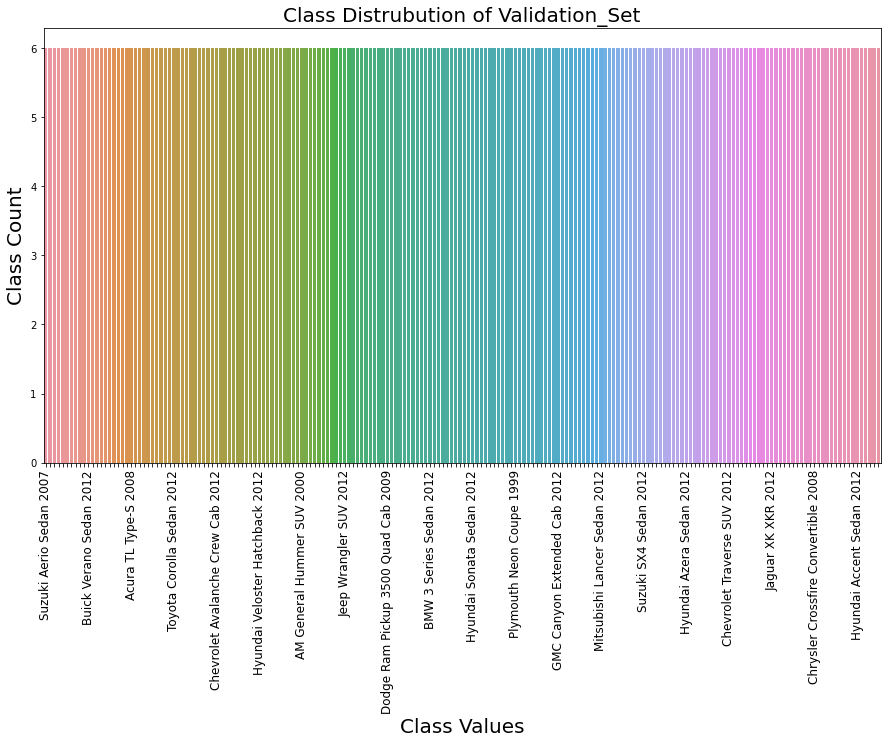

In [15]:
# Class distribution of Validation set
plt.figure(figsize = (15, 8))
plot_ = sns.countplot(x = val_df['class'])
plt.title('Class Distrubution of Validation_Set', fontsize = 20)
plt.xlabel('Class Values', fontsize = 20)
plt.ylabel('Class Count', fontsize = 20)
plt.xticks(rotation = 90, fontsize = 12)
for ind, label in enumerate(plot_.get_xticklabels()):
  if (ind % 10) == 0:
    label.set_visible(True)
  else:
    label.set_visible(False)
plt.show()

### Test Set

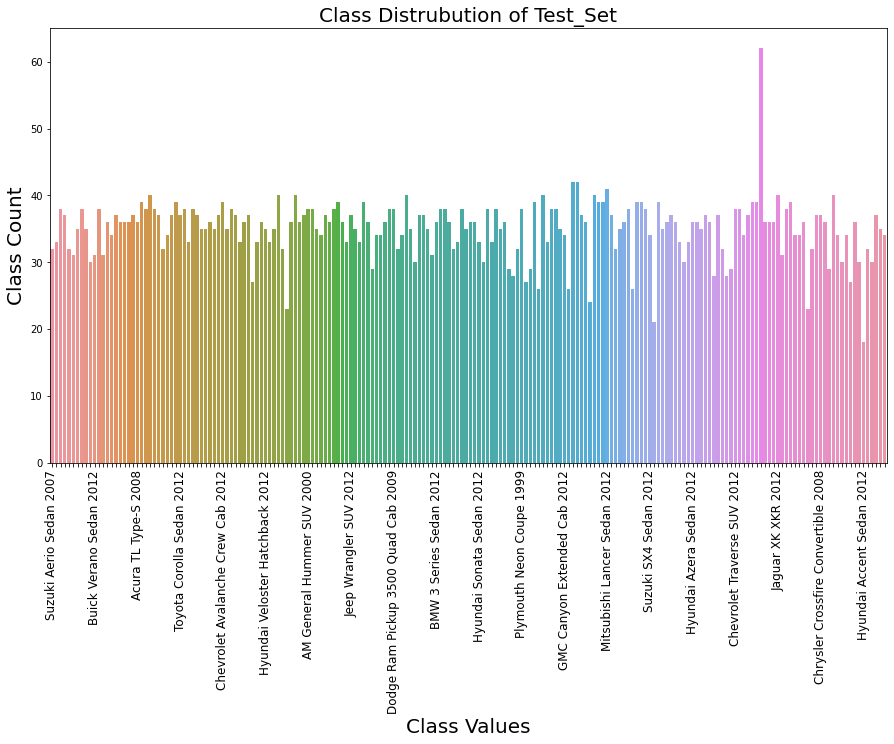

In [16]:
# Class distribution of Test set
plt.figure(figsize = (15, 8))
plot_ = sns.countplot(x = test_df['class'])
plt.title('Class Distrubution of Test_Set', fontsize = 20)
plt.xlabel('Class Values', fontsize = 20)
plt.ylabel('Class Count', fontsize = 20)
plt.xticks(rotation = 90, fontsize = 12)
for ind, label in enumerate(plot_.get_xticklabels()):
  if (ind % 10) == 0:
    label.set_visible(True)
  else:
    label.set_visible(False)
plt.show()

## Visualize Data

### Training Set

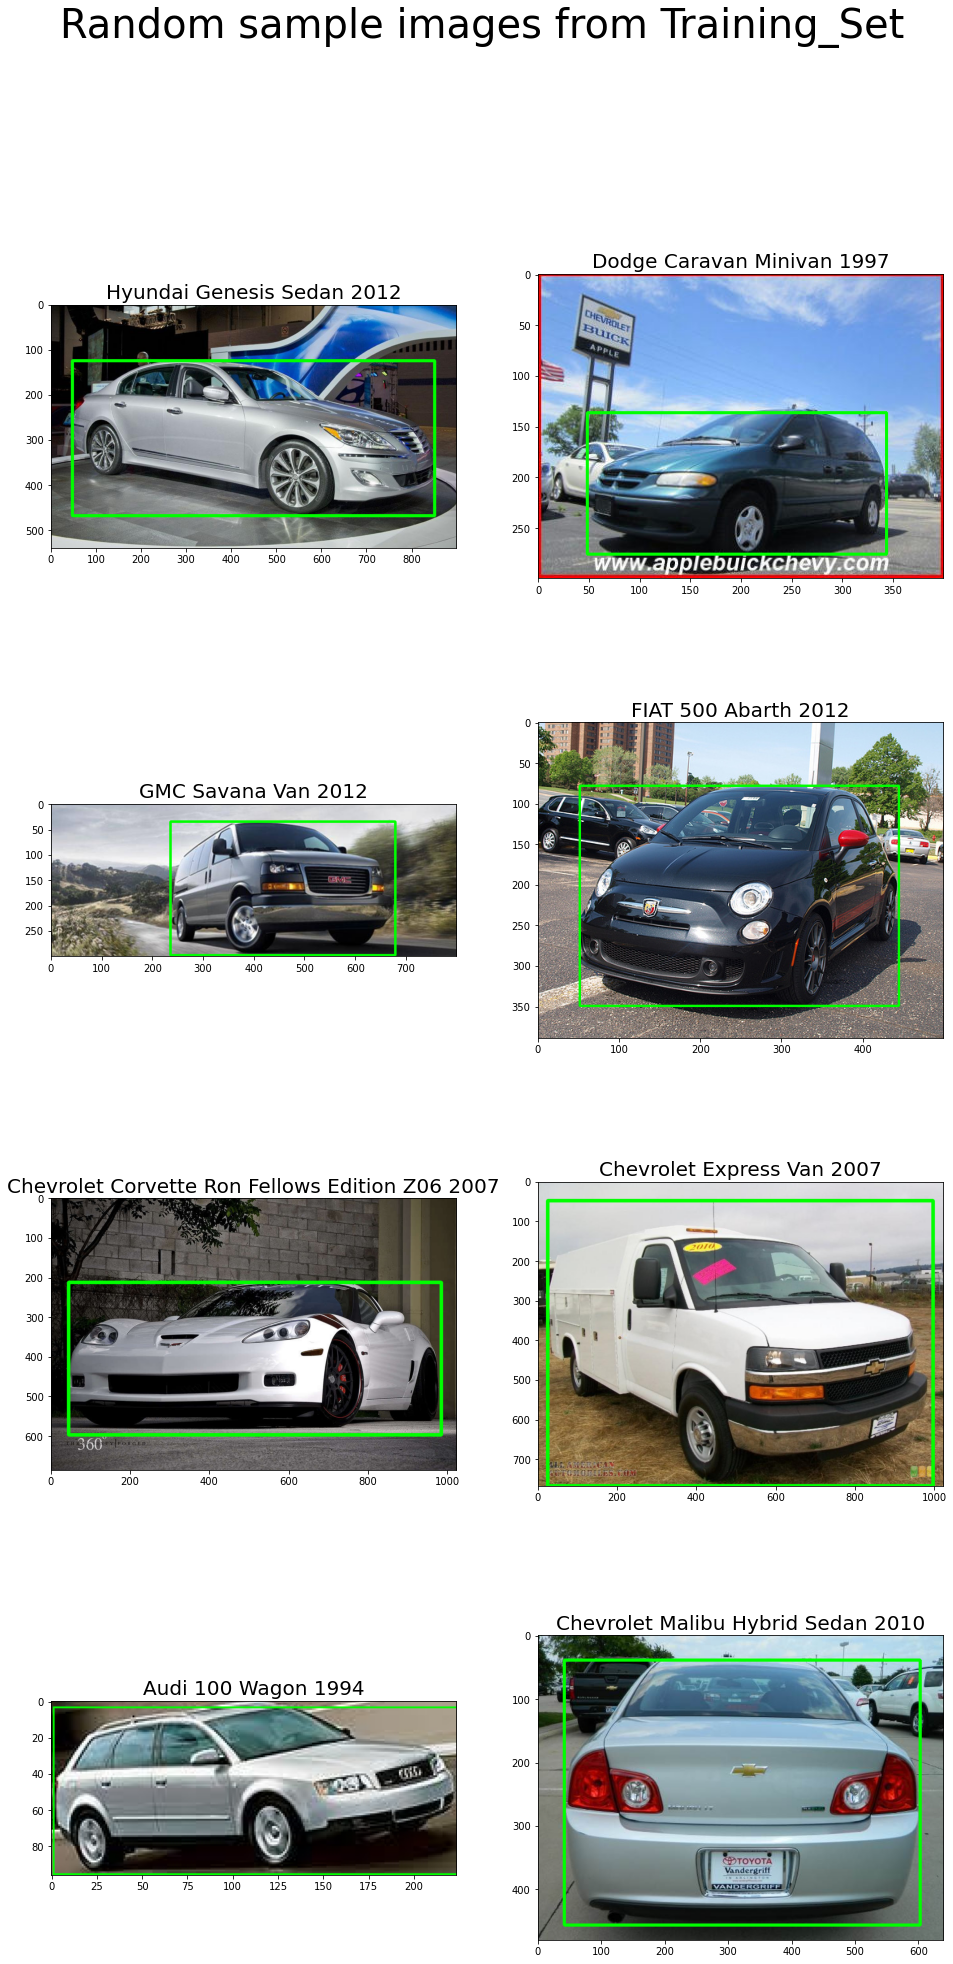

In [17]:
# Plot random images from training set
viz_data_from_df('Training_Set', train_df, 'filename', 'class', train_img_path, False, True, 8, 2, 8, 8)

### Validation Set

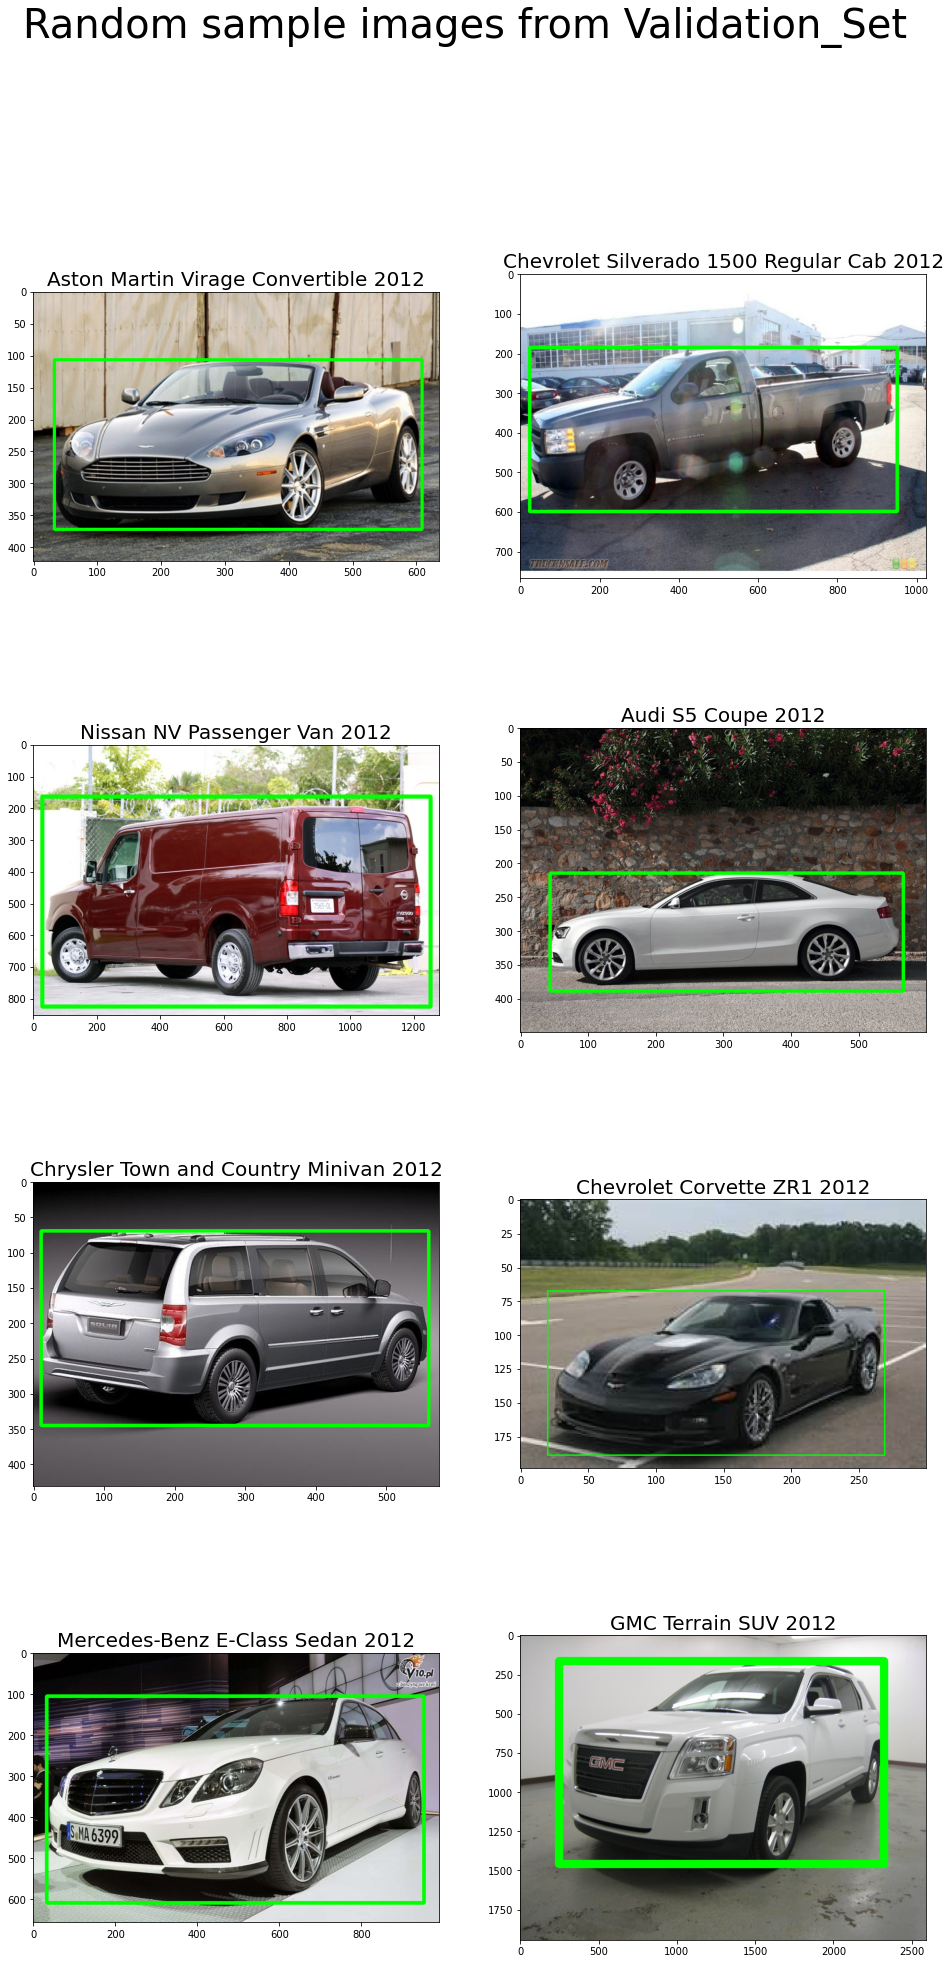

In [18]:
# Plot random images from validationg set
viz_data_from_df('Validation_Set', val_df, 'filename', 'class', val_img_path, False, True, 8, 2, 8, 8)

### Test Set

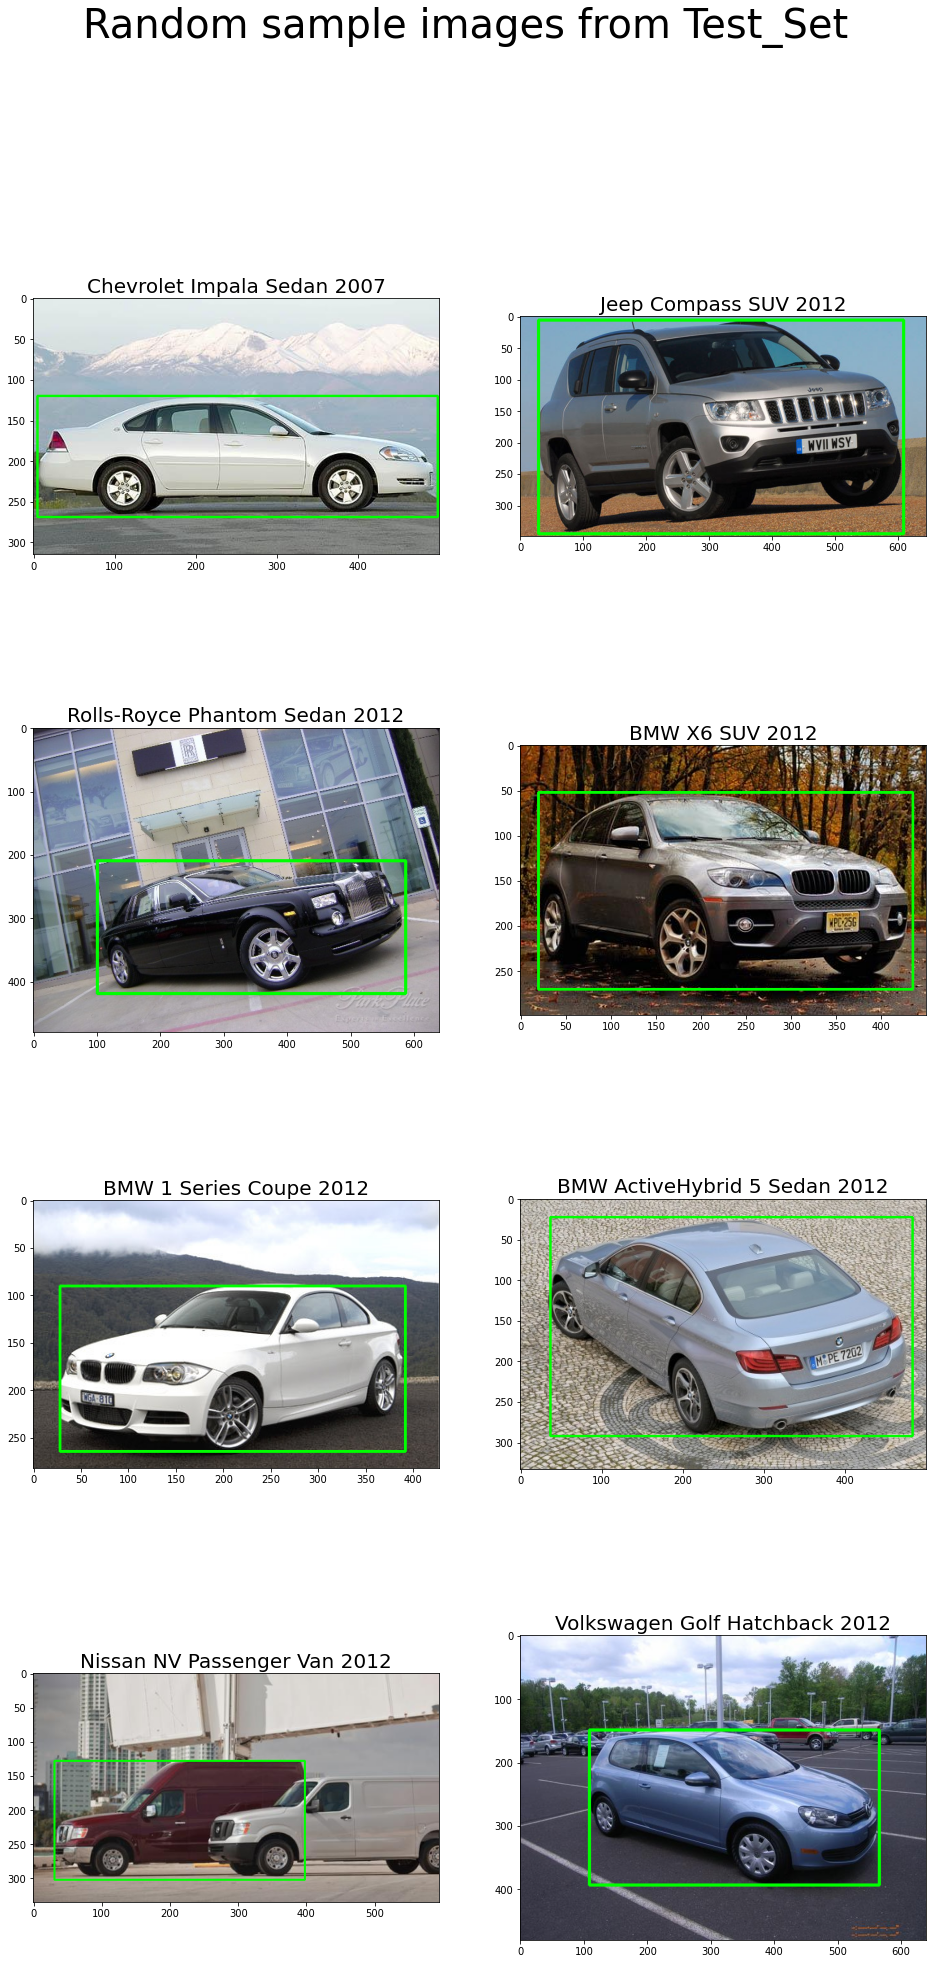

In [19]:
# Plot random images from test set
viz_data_from_df('Test_Set', test_df, 'filename', 'class', test_img_path, False, True, 8, 2, 8, 8)

# Backup

In [ ]:
print(f"Number of samples in training set is {len(train_dataset)}")
print(f"Number of samples in training set is {len(val_dataset)}")
print(f"Number of samples in test set is {len(test_dataset)}")

## Extract some information about dataset

In [ ]:
print(f"List of classes in training set:")
print(f"--------------------------------")
train_dataset.classes

<b>There are 10 output classes.</b>

In [ ]:
print(f"Class to Index mapping in training set:")
print(f"---------------------------------------")
train_dataset.class_to_idx

In [ ]:
# Extract first sample from train, val and test dataset and display some properties
# Training Set
print("Training_Set_Information:")
print("-------------------------")
img, label = train_dataset[0]
print(f"Total number of samples: {len(train_dataset)}")
print(f"Type of images: {type(img)}")
print(f"Data Type of images: {img.dtype}")
print(f"Shape of images: {img.shape}")
print(f"Min value of img: {img.min()}")
print(f"Max value of img: {img.max()}")
print(f"Label of first sample: {label}")
print()

# Validation Set
print("Validation_Set_Information:")
print("-------------------------")
img, label = val_dataset[0]
print(f"Total number of samples: {len(val_dataset)}")
print(f"Type of images: {type(img)}")
print(f"Data Type of images: {img.dtype}")
print(f"Shape of images: {img.shape}")
print(f"Min value of img: {img.min()}")
print(f"Max value of img: {img.max()}")
print(f"Label of first sample: {label}")
print()

# Test Set
print("Test_Set_Information:")
print("-------------------------")
img, label = test_dataset[0]
print(f"Total number of samples: {len(test_dataset)}")
print(f"Type of images: {type(img)}")
print(f"Data Type of images: {img.dtype}")
print(f"Shape of images: {img.shape}")
print(f"Min value of img: {img.min()}")
print(f"Max value of img: {img.max()}")
print(f"Label of first sample: {label}")
print()

<b>The above data shows that the images all three datasets are PyTorch Tensors of size (28, 28)encoded in grayscale float 32 format. Label is a scalar output.</b>

## Get class distribution

In [ ]:
# Extract labels of train, val and test datasets
y_train = (train_dataset.targets).numpy()
y_val = (val_dataset.dataset.targets).numpy()
y_test = (test_dataset.dataset.targets).numpy()

In [ ]:
sns.set(color_codes = True)
fig = plt.figure(figsize = (20, 8))
fig.suptitle('Distribution of classes', fontsize = 30)

ax1 = plt.subplot(1, 3, 1)
sns.countplot(y_train)
ax1.set_title('Training_Set', fontsize = 20)
ax1.set_xlabel('Class Values', fontsize = 20)
ax1.set_ylabel('Class Distribution', fontsize = 20)

ax2 = plt.subplot(1, 3, 2)
sns.countplot(y_val)
ax2.set_title('Validation_Set', fontsize = 20)
ax2.set_xlabel('Class Values', fontsize = 20)
ax2.set_ylabel('Class Distribution', fontsize = 20)

ax2 = plt.subplot(1, 3, 3)
sns.countplot(y_test)
ax2.set_title('Test_Set', fontsize = 20)
ax2.set_xlabel('Class Values', fontsize = 20)
ax2.set_ylabel('Class Distribution', fontsize = 20)
plt.show()

<b>Class distribution is reasonably uniform for all three sets.</b>

In [ ]:
# Collate class frequency counts into a dataframe
class_dist_df = pd.DataFrame(np.bincount(y_train), columns=['Training_Set'])
class_dist_df.index.name = 'Class_Label'
class_dist_df['Val_Set'] = np.bincount(y_val)
class_dist_df['Test_Set'] = np.bincount(y_test)

display(class_dist_df)

## Visualize some images from the three datasets

In [ ]:
viz_data_from_dset('Training_Set', train_dataset, 'float', 'grayscale', num_images = 10, num_cols = 5,\
                   col_size = 5, row_size = 6)
viz_data_from_dset('Validation_Set', val_dataset, 'float', 'grayscale', num_images = 10, num_cols = 5,\
                   col_size = 5, row_size = 6)
viz_data_from_dset('Test_Set', test_dataset, 'float', 'grayscale', num_images = 10, num_cols = 5,\
                   col_size = 5, row_size = 6)

# Batch generation

## Define base model, target image shape and model batch size

In [ ]:
### The base model defined here (bm_name) will be used to choose the appropriate pre-processing function
### to apply to the input images in the Image Data Generators

### If bm_name = 'VGG16' or 'ResNet50':
###    Only mean shift is applied
###    img_preprocessed = img - [103.939, 116.779, 123.68]
### If bm_name = 'MobileNet' or 'InceptionV3'
###    Image scaled to lie between -1 and +1
###    img_preprocessed = (img / 127.5) - 1
### If bm_name = 'grayscale_model'
###    Image scaled to lie between 0 and +1
###    img_preprocessed = (img / 225.)

# bm_name = 'VGG16'
# bm_name = 'ResNet50'
# bm_name = 'MobileNet'
# bm_name = 'InceptionV3'\
bm_name = 'grayscale_model'

# Define target image size and batch size 
mod_inp_shape = (1, 28, 28) # Define target image size for model input
mod_bat_size = 128 # Batch size to use while model fitting

## Define batch generators

In [ ]:
train_dataloader = DataLoader(train_dataset, mod_bat_size, shuffle = True)
val_dataloader = DataLoader(val_dataset, mod_bat_size, shuffle = True)
test_dataloader = DataLoader(test_dataset, mod_bat_size, shuffle = True)

## Verify batch generators

In [ ]:
print("Train Dataloader:")
print("-----------------")
print(f"Total number of batches: {len(train_dataloader)}")
print(f"Size of each batch: {train_dataloader.batch_size}")
print()
print("Val Dataloader:")
print("---------------")
print(f"Total number of batches: {len(val_dataloader)}")
print(f"Size of each batch: {val_dataloader.batch_size}")
print()
print("Test Dataloader:")
print("---------------")
print(f"Total number of batches: {len(test_dataloader)}")
print(f"Size of each batch: {test_dataloader.batch_size}")

In [ ]:
X_batch, y_batch = next(iter(train_dataloader))
print(f"Type of X_batch is {type(X_batch)}")
print(f"Type of y_batch is {type(y_batch)}")
print(f"Shape of X_batch is {X_batch.shape}")
print(f"Shape of y_batch is {y_batch.shape}")
# print(f"Minimum value of X_batch is {X_batch.min()}")
# print(f"Maximum value of X_batch is {X_batch.max()}")
# print(f"Data_Type of X_batch is {X_batch.dtype}")


## Visualize the data from generator objects

In [ ]:
# Generate a batch of data from train_generator
X_batch, y_batch = next(iter(train_dataloader))
X_batch, y_batch = (X_batch.numpy(), y_batch.numpy())
viz_data_from_array('Train_Dataloader', X_batch, y_batch, 'float', 'grayscale', num_images = 10,\
                    num_cols = 5, col_size = 5, row_size = 6)
print("\n\n")
# Generate a batch of data from validation_generator
X_batch, y_batch = next(iter(val_dataloader))
X_batch, y_batch = (X_batch.numpy(), y_batch.numpy())
viz_data_from_array('Val_Dataloader', X_batch, y_batch, 'float', 'grayscale', num_images = 10,\
                    num_cols = 5, col_size = 5, row_size = 6)
print("\n\n")
# Generate a batch of data from test_generator
X_batch, y_batch = next(iter(test_dataloader))
X_batch, y_batch = (X_batch.numpy(), y_batch.numpy())
viz_data_from_array('Test_Dataloader', X_batch, y_batch, 'float', 'grayscale', num_images = 10,\
                    num_cols = 5, col_size = 5, row_size = 6)
print("\n\n")

# Model - Build, Train, Tune

## Classes

### Define Class: Model

In [ ]:
class Model(nn.Module):
  def __init__(self, model_dict):
    super(Model, self).__init__()
    
    # Extract parameters from model_dict
    self.model_arch = model_dict['model_arch'] # Model Architecture
    self.dropout_rate = model_dict['dropout_rate'] # List containing dropout values for each layer
    
    # Define layers used in the model
    self.flatten = nn.Flatten()
    self.ReLU = nn.ReLU()
    self.pool = nn.MaxPool2d(2, 2)
    self.conv1 = nn.Conv2d(1, 32, 3, padding = 1)        
    self.conv2 = nn.Conv2d(32, 32, 3, padding = 1)
    self.linear1 = nn.Linear(1568, 128)
    self.linear2 = nn.Linear(128, 64)
    self.linear3 = nn.Linear(64, 10)
    self.linear4 = nn.Linear(1568, 512)
    self.linear5 = nn.Linear(512, 256)
    self.linear6 = nn.Linear(256, 10)
    self.drop1 = nn.Dropout(p = self.dropout_rate[0])
    self.drop2 = nn.Dropout(p = self.dropout_rate[1])
    self.drop3 = nn.Dropout(p = self.dropout_rate[2])

  def forward(self, x):

    ##### Start Model Architecture A
    if (self.model_arch == 'A'): 
      x = self.pool(self.ReLU(self.conv1(x)))
      x = self.pool(self.ReLU(self.conv2(x)))
      x = self.drop1(self.flatten(x))
      x = self.drop2(self.ReLU(self.linear1(x)))
      x = self.drop3(self.ReLU(self.linear2(x)))
      x = self.linear3(x)
      return x
    ##### End Model Architecture A 

    ##### Start Model Architecture B
    if (self.model_arch == 'B'): 
      x = self.pool(self.ReLU(self.conv1(x)))
      x = self.pool(self.ReLU(self.conv2(x)))
      x = self.drop1(self.flatten(x))
      x = self.drop2(self.ReLU(self.linear4(x)))
      x = self.drop3(self.ReLU(self.linear5(x)))
      x = self.linear6(x)
      return x
    ##### End Model Architecture B     

### Verify Class: Model

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
# Verify model defined above
model_dict = {'model_arch': 'A',
              'dropout_rate': [0.1, 0.2, 0.3]
              }
temp_model = Model(model_dict).to(device)
ts_summary(temp_model, input_size = mod_inp_shape)

## Functions

### Define Function: loss_opt_sch

In [ ]:
def loss_opt_sch(model, loss_opt_sch_dict):
    
    """
    Function to define the loss function, optimizer and learning rate scheduler
    
    Arguments:
      model - Model object
      loss_opt_sch_dict - Dictionary with list of keys / values needed to define the loss function
                          optimizer and learning rate scheduler
 
    """    
    # Retrieve compile_dict parameters
    ilr = loss_opt_sch_dict['ilr'] # Initial learning rate
    lr_sched = loss_opt_sch_dict['lr_sched'] # Type of learning rate scheduler to use
                              
    loss_func = nn.CrossEntropyLoss() # Define loss function
    opt = optim.Adam(model.parameters(), lr = ilr) # Define optimizer

    # Define scheduler to use
    if (lr_sched == None): # No LR scheduler
      sch = None
    elif (lr_sched == 'exp'): # Use exponential decay LR scheduler
      lr_decay_epochs = loss_opt_sch_dict['lr_decay_epochs'] # See comment for lr_decay_level 
      lr_decay_level = loss_opt_sch_dict['lr_decay_level'] # Decay learning rate to ilr * lr_decay_level 
                                                           # exponentially in lr_decay_epochs
      gamma = lr_decay_level ** (1 / lr_decay_epochs) # Compute learning rate decay per epoch
      sch = optim.lr_scheduler.ExponentialLR(opt, gamma = gamma) # Define exponential decay scheduler    

    return loss_func, opt, sch

### Define train_epoch

In [ ]:
def train_epoch(model, train_dl, opt, loss_func, epoch, epochs, device, verb):

  """
  Function to train one epoch of the model
  
  Arguments:
    model - Model instance that needs to be trained
    train_dl - Train Dataloader to use for training
    opt - Optimizer to use for training
    loss_func - Loss Function to use for training
    epoch - Current epoch that is being trained
    epochs - Total number of epochs to train
    device - Type of device to use (cpu or gpu)
    verb - Boolean. If True, display training progress during training

  Returns:
    train_loss_avg - Average training loss during current epoch training
    train_acc_avg - Average training accuracy during current epoch training
    """     
  
  train_start_time = datetime.datetime.now() # Start time

  train_loss_cum = 0 # Placeholder to store cumulative training loss
  train_corr_pred_cum = 0 # Placeholder to store cumulative number of correct predictions
  tot_samp = 0 # Placeholder to store total training samples seen till now.
  
  # Start training of current epoch
  model.train() # Set model to training mode

  for batch_num, (X_batch, y_batch) in enumerate(train_dl): # Loop through training batches
    X_batch, y_batch = X_batch.to(device), y_batch.to(device)
    
    # Forward-prop, eval loss and back-prop
    opt.zero_grad() # Zero out gradients
    y_pred = model(X_batch) # Forward-Prop current batch through model
    loss_batch = loss_func(y_pred, y_batch) # Compute loss of current batch
    loss_batch.backward() # Compute gradients
    opt.step() # Update parameters

    # Compute cumulative loss and average loss till current batch
    num_samp = len(X_batch) # Get number of samples in current batch
    tot_samp += num_samp # Update total number of samples seen till current batch
    train_loss_cum += loss_batch * num_samp # Update cumulative training loss till current batch
    train_loss_avg = train_loss_cum / tot_samp # Compute average training loss till current batch

    # Compute cumulative correct predictions and average accuracy till current batch
    train_corr_pred_batch = (y_pred.argmax(dim = 1) == y_batch).float().sum().item()
    train_corr_pred_cum += train_corr_pred_batch  
    train_acc_avg = 100 * (train_corr_pred_cum / tot_samp) # Average accuracy on training set 
                                                        # till current batch
    if (verb): # Display training progress if verb = 1
      stdout.write(f"\rEpoch: {epoch}/{epochs}, Batch: {batch_num + 1}/{len(train_dl)}, ")
      stdout.write(f"LR: {opt.param_groups[0]['lr']:0.2e}, ")
      stdout.write(f"Train_Loss: {train_loss_avg:0.4f}, Train_acc: {train_acc_avg:0.2f}%, ")
      stdout.flush   

  train_end_time = datetime.datetime.now() # End time
  train_time = ((train_end_time - train_start_time).total_seconds())/60 # Elapsed time

  return train_time, train_loss_avg, train_acc_avg

### Define eval_epoch

In [ ]:
def eval_epoch(model, dl, loss_func, device):

  """
  Function to evaluate loss and accuracy of dataloader 'dl' with current model parameters
  
  Arguments:
    model - Model instance on which evaluation needs to be done
    dl - Dataloader to use for evaluation
    loss_func - Loss Function to use for training
    device - Type of device to use (cpu or gpu)

  Returns:
    loss_avg - Average loss during current epoch training
    acc_avg - Average accuracy during current epoch training
    """        
      
  val_start_time = datetime.datetime.now() # Start time

  loss_cum = 0 # Placeholder to store cumulative loss
  corr_pred_cum = 0 # Placeholder to store cumulative number of correct predictions
  model.eval() # Set NN to evaluation mode
  with torch.no_grad():
    for X_batch, y_batch in dl: # Loop through val_dl batches
      X_batch, y_batch = X_batch.to(device), y_batch.to(device)
      y_pred = model(X_batch) # Forward-Prop current batch through model
      
      # Obtain cumulative loss
      loss_batch = loss_func(y_pred, y_batch) # Compute loss of current batch
      loss_cum += loss_batch * len(X_batch) # Update cumulative loss till current batch
      
      # Obtain cumulative number of correct predictions
      corr_pred_cum += (y_pred.argmax(dim = 1) == y_batch).float().sum().item()

    loss_avg = loss_cum / len(dl.dataset) # Obtain averaged loss
    acc_avg = 100 * corr_pred_cum / len(dl.dataset) # Obtain averaged accuracy

  val_end_time = datetime.datetime.now() # End time
  val_time = ((val_end_time - val_start_time).total_seconds())/60 # Elapsed time

  return val_time, loss_avg, acc_avg

### Define Model_Fit

In [ ]:
def model_fit(model, opt, loss_func, sch, train_dict, device):
    
    """
    Function to fit the model
    
    Arguments:
      model - Model instance that needs to be trained
      opt - Optimizer to use for training
      loss_func - Loss Function to use for training
      sch - Learning rate scheduler to use for training
      train_dict - Dictionary with list of keys / values needed to fit the model
      device - Type of device to use (cpu or gpu)            

    Returns:
      model - Final trained model
      hist - Model training history
    """   

    # Retrieve path parameters
    tb_path = train_dict['tb_path'] # Path to store Tensorboard callback information
    to_path = train_dict['to_path'] # Training outputs path
    
    # Define path for tensorboard logs
    if (tb_path != None):
      logdir = os.path.join(tb_path,\
                            datetime.datetime.now(pytz.timezone('Asia/Kolkata')).strftime("%d%m_%H%M"))
      logdir_train = os.path.join(logdir, 'train') # TB Log directory for training set results
      logdir_val = os.path.join(logdir, 'val') # TB Log directory for validation set results
      writer_train = SummaryWriter(log_dir = logdir_train)
      writer_val = SummaryWriter(log_dir = logdir_val)

    # Retrieve training parameters
    train_dl = train_dict['train_dl'] # Train dataloader to use while fitting
    val_dl = train_dict['val_dl'] # Validation dataloader to use while fitting
    initl_epoch = train_dict['initl_epoch'] # Initial epoch to start training from
    final_epoch = train_dict['final_epoch'] # Final epoch to train upto.
    verb = train_dict['verb'] # Controls verbosity level of model fit.
    mcp_freq = train_dict['mcp_freq'] # Checkpoint model after mcp_freq epochs
    val_freq = train_dict['val_freq'] # Number of epochs to run before performing a validation run    

    # Define placeholder to store training history
    loss_train_hist = [] # Placeholder to store training loss values at the end of each epoch
    loss_val_hist = [] # Placeholder to store validation loss values at the end of each epoch
    acc_train_hist = [] # Placeholder to store average training accuracy values at the end of each epoch
    acc_val_hist = [] # Placeholder to store validation accuracy values at the end of each epoch
    hist = {} # Placeholder to store overall training history
    
    #### Start training loop here

    for epoch in range(initl_epoch, (final_epoch + 1)): # Loop through epochs
      if (verb): stdout.write("\n")
      
      # Train current epoch of model
      train_time, train_loss_avg, train_acc_avg = train_epoch(model, train_dl, opt, loss_func, epoch,\
                                                              final_epoch, device, verb)
      # Update Tensorboard SummaryWriter
      if (tb_path != None): 
        writer_train.add_scalar('LR', opt.param_groups[0]['lr'], epoch)
        writer_train.add_scalar('Loss', train_loss_avg.item(), epoch)
        writer_train.add_scalar('Accuracy', train_acc_avg, epoch)     
      # Update training history
      loss_train_hist.append(train_loss_avg.item()) # Update training loss
      acc_train_hist.append(train_acc_avg) # Update training set accuracy          

      # Evaluate model on validation set
      if ((epoch == initl_epoch) or ((epoch % val_freq) == 0) or (epoch == final_epoch)): 
        val_time, val_loss_avg, val_acc_avg = eval_epoch(model, val_dl, loss_func, device)
        # Display evaluation results if verb = 1
        if (verb): 
          stdout.write(f"Val_Loss: {val_loss_avg:0.4f}, Val_Acc: {val_acc_avg:0.2f}%, ")
          stdout.write(f"Training Time: {train_time:0.2f} minutes, ")
          stdout.write(f"Val Time: {val_time:0.2f} minutes.")
        # Update Tensorboard SummaryWriter
        if (tb_path != None): 
          writer_val.add_scalar('Loss', val_loss_avg.item(), epoch)
          writer_val.add_scalar('Accuracy', val_acc_avg, epoch) 
      else:
          stdout.write(f"Training Time: {train_time:0.2f} minutes.")   
      # Update val set evaluation history
      loss_val_hist.append(val_loss_avg.item()) # Update validation loss
      acc_val_hist.append(val_acc_avg) # Update validation set accuracy               

      # Update LR scheduler
      if (sch != None): sch.step()   

      # Store intermediate model checkpoint
      if ((epoch % mcp_freq) == 0): 
        # Path to use for saving final checkpoint
        mcp_path = to_path + "_ckpt_EP" + str(f"{epoch:04d}") + ".pt"
        # Create checkpoint dictionary
        ckpt_dict = {'model_state_dict': model.state_dict(), # Current model state_dict
                     'opt_state_dict': opt.state_dict(), # Current optimizer state_dict
                    }
        torch.save(ckpt_dict, mcp_path) # Save model checkpoint
        stdout.write(f" Model Checkpoint Created.")                    

    #### End of training loop

    # Create training history dictionary
    hist['train_loss'] = np.array(loss_train_hist)
    hist['val_loss'] = np.array(loss_val_hist)
    hist['train_accuracy'] = np.array(acc_train_hist)
    hist['val_accuracy'] = np.array(acc_val_hist)

    # Close Tensorboard summary writers
    if (tb_path != None):
      writer_train.close() # Close Tensorboard SummaryWriter
      writer_val.close() # Close Tensorboard SummaryWriter    
    
    if (verb): stdout.write("\n\n")

    return model, hist    

### Define Model_Train

In [ ]:
def model_train(model_dict, loss_opt_sch_dict, train_dict, device, model = None, opt = None,\
                loss_func = None, sch = None):
  """
  Function to instantiate (or load) model, define loss, optimizer, learning rate scheduler 
  and fit model.
    
  Arguments:
    model_dict - Dictionary with list of keys / values needed to build the model
    loss_opt_sch_dict - Dictionary with list of keys / values needed to define loss, 
                        optimizer and LR scheduler
    train_dict - Dictionary with list of keys / values needed to train the model
    device - Type of device to use (cpu or gpu)    
    model - Pre-trained model (Pass this as input only if fit_resume = True and load_model = False)
    opt - Pre-defined optimizer (Pass this as input only if fit_resume = True and load_model = False)    
    loss_func - Pre-defined loss_function (Pass this as input only if fit_resume = True 
                and load_model = False)        
    sch - Pre-defined LR scheduler (Pass this as input only if fit_resume = True and load_model = False)        
    
  Returns:
    model - Final trained model
    hist - Model training history
    loss_func - Loss function used for training
    opt - Optimizer used for training
    sch - LR scheduler used for training
 
  """   
  # Retrieve train_dict parameters
  fit_resume = train_dict['fit_resume'] # Boolean: If True, resume fit from initial epoch
  load_model = train_dict['load_model'] # Boolean: If True, load model from 'fm_path' and resume fit  
  to_path = train_dict['to_path'] # Training outputs path

  if (not(fit_resume)): # fit_resume = False => instantiating new model
    print("Instantiating new model...", end = ', ')
    model = Model(model_dict).to(device) # Instantiate new model
    print("Setting loss, opt, sch...", end = ', ')
    loss_func, opt, sch = loss_opt_sch(model, loss_opt_sch_dict)
    print("Model Fit started....")    
    model, hist = model_fit(model, opt, loss_func, sch, train_dict, device) # Fit model
  else: # fit_resume = True => Proceed with existing model in memory or load model from disk
    if (load_model): # load_model = True => Load model from disk
      print("Loading model from disk...", end = ', ')
      fm_path = to_path + "_finalmodel.pt" # Path to read saved model from
      model = torch.load(fm_path) # Reload model from disk
      print("Setting loss, opt, sch...", end = ', ')
      loss_func, opt, sch = loss_opt_sch(model, loss_opt_sch_dict)
      print("Updating model, optimizer state from checkpoint...", end = ', ')
      cp_path = to_path + "_finalckpt.pt" # Path to read saved checkpoint from
      ckpt = torch.load(cp_path) # Load saved checkpoint dictionary    
      model.load_state_dict(ckpt['model_state_dict']) # Update model state
      opt.load_state_dict(ckpt['opt_state_dict']) # Update optimizer state
      print("Resuming model fit....")
      model, hist = model_fit(model, opt, loss_func, sch, train_dict, device) # Resume model fit      
    else: # load_model = False => Proceed with existing model in memory
      print("Using existing model instance in memory...", end = ', ')
      print("Resuming model fit....")
      model, hist = model_fit(model, opt, loss_func, sch, train_dict, device) # Resume model fit

  # Create checkpoint dictionary
  ckpt_dict = {'model_state_dict': model.state_dict(), # Final model state_dict
               'opt_state_dict': opt.state_dict(), # Final optimizer state_dict
              }

  # Save final trained model and history to file
  if (to_path != None):
    fm_path = to_path + "_finalmodel.pt" # Path to use for saving final output model
    hi_path = to_path + "_hist.npy" # Path to use for saving training history
    # Path to use for saving final checkpoint
    fcp_path = to_path + "_finalckpt_EP" + str(f"{train_dict['final_epoch']:04d}") + ".pt" 
    
    torch.save(model, fm_path) # Save final trained model
    torch.save(ckpt_dict, fcp_path) # Save final model checkpoint
    np.save(hi_path, hist) # Save training history

  return model, hist, loss_func, opt, sch

## Set model_core, model_compile, model_train parameters

In [ ]:
### Define file paths
mod_file_pref = "MA" # Prefix to use for naming files and paths
tb_path = os.path.join(tb_logs_base_path, mod_file_pref) # Tensorboard base path
to_path = os.path.join(out_base_path, mod_file_pref) # Training outputs path

# Set model_dict values
model_dict = {'model_arch': 'A',
              'dropout_rate': [0.0, 0.0, 0.0]
              }

# Set loss_opt_sch_dict values
loss_opt_sch_dict = {'ilr': 1e-3, # Initial learning rate
                     'lr_sched': 'exp', # Type of learning rate scheduler to use
                     'lr_decay_epochs': 10, # See comment for lr_decay_level 
                     'lr_decay_level': 0.1, # Decay learning rate to ilr * lr_decay_level exponentially
                                            # in lr_decay_epochs
                    }

# Set train_dict values               
train_dict = {'fit_resume': False, # Boolean: If True, resume fit from initial epoch
              'load_model': False, # Boolean: If True, load model from 'fm_path' and resume fit
              'train_dl': train_dataloader, # Train dataloader to use while fitting
              'val_dl': val_dataloader, # Validation dataloader to use while fitting
              'initl_epoch': 1, # Starting epoch number (set this to 1 if training a new model)
              'final_epoch': 7, # Final epoch number
              'val_freq': 5, # Number of epochs to run before performing a validation run
              'verb': 1, # Controls verbosity level of model fit.
              'mcp_freq': 100, # Checkpoint model after mcp_freq epochs
              'tb_path': tb_path, # Path to store Tensorboard callback information
              'to_path': to_path, # Path to store outputs of model training              
              }

print(tb_path)
print(to_path)

## Launch Tensorboard

In [ ]:
%tensorboard --logdir {tb_logs_base_path}

## Train Model

In [ ]:
# # Get type of device (cpu or gpu) for training.
# device = "cuda" if torch.cuda.is_available() else "cpu"

# # Get start time of run and display it
# start_time = datetime.datetime.now(pytz.timezone('Asia/Kolkata'))
# print("Started at %s; Using '%s' for training..." %(start_time.strftime("%H:%M:%S"), device.upper()))

# # Instantiate and fit model
# if (train_dict['fit_resume'] and not(train_dict['load_model'])):
#   model, hist, loss_func, opt, sch = model_train(model_dict, loss_opt_sch_dict, train_dict, device,\
#                                                  model, opt, loss_func, sch)
# else:
#   model, hist, loss_func, opt, sch = model_train(model_dict, loss_opt_sch_dict, train_dict, device)

# # Get end time of run and display elapsed time
# end_time = datetime.datetime.now(pytz.timezone('Asia/Kolkata'))
# elap_time = ((end_time - start_time).total_seconds())/60
# print("Completed at %s. Elapsed time = %0.2f minutes." %(end_time.strftime("%H:%M:%S"), elap_time))

# Results Summary

## Define Functions

### Function: get_model

In [ ]:
def get_model(mod_file_prefix, device, mod_inp_shape, print_summary = False):
  '''
  Function to return required paths, loaded model and print model summary

  Arguments:
    mod_file_prefix: # Prefix of model file name
    device: 'cpu' or 'cuda'
    mod_inp_Shape: Shape of input to model
    print_summary: Boolean. If True, print model summary
  '''
  fm_path = os.path.join(out_base_path, mod_file_pref + "_finalmodel.pt") # Final model path
  hi_path = os.path.join(out_base_path, mod_file_pref + "_hist.npy") # History file path
  
  # Load model with final trained weights
  model = torch.load(fm_path)

  # Move model to GPU if available and set to eval mode
  model = model.to(device) 
  model.eval()
  
  # Print model summary
  if (print_summary):
    display(ts_summary(model, input_size = mod_inp_shape))

  return fm_path, hi_path, model

### Function: plot_lc

In [ ]:
def plot_lc(mod_file_pref, hi_path, hist_plot_dict, num_cols, col_size, row_size):
  '''
  Function to plot learning curves 

  Arguments:
    hi_path: path of history file
    hist_plot_dict: Dictionary containing items to plot
    num_cols: Number of columns to use for plotting
    col_size: Column width to use while plotting
    row_size: Row width to use while plotting
  '''
  hist_model = np.load(hi_path, allow_pickle = 'TRUE').item()
  
  num_plots = len(hist_plot_dict)
  num_rows = math.ceil(num_plots / num_cols) # Number of rows to use for plotting

  plt.style.use('default')
  fig = plt.figure(figsize = ((num_cols * col_size), (num_rows * row_size)))
  fig.suptitle(mod_file_pref + " Learning Curves", fontsize = 20)

  for ind, value in enumerate(hist_plot_dict.items()):
    ax = plt.subplot(num_rows, num_cols, (ind + 1))
    for key in value[1][0].keys():
      epoch_range = np.arange(1, (len(hist_model[key]) + 1))
      xtick_size = math.ceil(len(epoch_range) / 10)
      epoch_ticks = np.arange(epoch_range[0], (epoch_range[-1] + 1), xtick_size)
      ax.plot(epoch_range, hist_model[key], value[1][0][key][0], label = value[1][0][key][1])     
      ax.set_xticks(ticks = epoch_ticks)
      ax.set_title(value[1][1], fontsize = 20)
      ax.set_ylabel(value[1][2], fontsize = 20)
      ax.set_xlabel(value[1][3], fontsize = 20)
      ax.grid(b = True)
      ax.legend(fontsize = 15)

### Function: model_eval

In [ ]:
def model_eval(model, loss_func, device, eval_dict):
  '''
  Function to evaluate model on different dataloaders based on an input dictionary eval_dict

  Arguments:
    model: Model instance to use for evaluation
    loss_func: Loss function to use for evaluating loss
    device: 'cpu' or 'cuda'
    eval_dict: Dictionary input with details on dataloaders to use for evaluation
  '''

  for title, dl in eval_dict.items():
    _, loss_avg, acc_avg = eval_epoch(model, dl, loss_func, device)
    print(title)
    print(('-' * len(title)))
    print(f"Loss is {loss_avg:0.4f}")
    print(f"Accuracy is {acc_avg:0.2f}%")
    print()

### Function: model_pred

In [ ]:
def model_pred(model, device, dl):
  '''
  Function to generate predictions from a model on a given dataloader

  Arguments:
    model: Model instance to use for prediction
    device: 'cpu' or 'cuda'
    dl: Dataloader on which predictions have to be done
  '''

  model.eval() # Set model to evaluation mode
  with torch.no_grad():
    for ind, (X_batch, y_batch) in enumerate(dl): # Loop through all batches in dl
      X_batch, y_batch = X_batch.to(device), y_batch.to(device)
      y_pred_batch = model(X_batch).argmax(dim = 1) # Make predictions on current batch
      if (ind == 0):
        y_pred = torch.clone(y_pred_batch)
      else:
        y_pred = torch.cat((y_pred, y_pred_batch), dim = 0)

  return y_pred

### Function: predict_and_plot

In [ ]:
def predict_and_plot_from_dset(dset, samp_indices, model, num_cols, col_size, row_size, fig_title):

  '''
  Function to make predictions on a subset of data and plot images with actual
  and predicted labels

  Arguments:
    dset: Dataset from which images will be sampled
    samp_indices: Indices from dset to be plotted
    model: Model instance to use for making predictions
    num_cols: Number of columns to use for plotting
    col_size: Size of columns to use for plotting
    row_size: Size of rows to use for plotting
    fig_title: Title to use for overall figure
  ''' 

  num_rows = math.ceil(len(samp_indices) / num_cols) # Number of rows to use for plotting
  fig = plt.figure(figsize = ((num_cols * col_size), (num_rows * row_size)))
  fig.suptitle(fig_title, fontsize = 40)

  for ind, samp_ind in enumerate(samp_indices):

    img, label_act = dset[samp_ind] # Extract current image and label from dataset
    img = img.unsqueeze(dim = 0).to(device) # Add batch axis
    img_plot = img.cpu().numpy() # Use this for plotting image

    with torch.no_grad(): y_pred = model(img) # Make prediction on current image

    label_pred = y_pred.argmax(dim = 1).cpu().numpy()[0] # Obtain predicted label
    pred_prob = 100 * (F.softmax(y_pred)[0, label_pred].cpu().numpy()) # Obtain prediction probability

    ax = plt.subplot(num_rows, num_cols, (ind + 1))
    ax.text(0.5, 1.35, f"Sample index is {samp_ind}", transform = ax.transAxes,\
            horizontalalignment = 'center', verticalalignment = 'center',\
            color = 'black', fontfamily = 'sans-serif', fontsize = '22')    
    ax.text(0.5, 1.20, f"Actual label is {label_act}", transform = ax.transAxes,\
            horizontalalignment = 'center', verticalalignment = 'center',\
            color = 'black', fontfamily = 'sans-serif', fontsize = '22')    
    ax.text(0.5, 1.05, f"Pred label is {label_pred} ({pred_prob:0.2f}%)", transform = ax.transAxes,\
            horizontalalignment = 'center', verticalalignment = 'center',\
            color = 'black', fontfamily = 'sans-serif', fontsize = '22')    
    ax.imshow(img_plot.squeeze(), cmap = 'gray')

  plt.show()

### Function: plot_cm

In [ ]:
def plot_cm(y_train_act, y_val_act, y_test_act, y_train_pred, y_val_pred, y_test_pred, row_size, col_size):

  '''
  Function to plot confusion matrices for train, val and test sets

  Arguments:
    y_train_act: Ground-truth training set labels
    y_val_act: Ground-truth validation set labels
    y_test_act: Ground-truth testing set labels
    y_train_pred: Predicted training set labels
    y_val_pred: Predicted validation set labels
    y_test_pred: Predicted testing set labels
    row_size: Row size to use for plotting
    col_size: Column size to use for plotting
  '''

  # Generate confusion matrices
  cm_train = confusion_matrix(y_train_act.cpu(), y_train_pred.cpu())
  cm_val = confusion_matrix(y_val_act.cpu(), y_val_pred.cpu()) 
  cm_test = confusion_matrix(y_test_act.cpu(), y_test_pred.cpu())

  # Convert confusion matrices to pandas DF
  index = [('A' + str(a)) for a in list(np.unique(y_train_act.cpu()).astype(np.int))]
  columns = [('P' + str(a)) for a in list(np.unique(y_train_act.cpu()).astype(np.int))]
  cm_train_df = pd.DataFrame(cm_train, index = index, columns = columns)
  cm_val_df = pd.DataFrame(cm_val, index = index, columns = columns)  
  cm_test_df = pd.DataFrame(cm_test, index = index, columns = columns)

  # Plot confusion matrices
  fig = plt.figure(figsize = (col_size, (3 * row_size)))

  ax1 = plt.subplot(3, 1, 1)
  sns.heatmap(cm_train_df, annot_kws = {"fontsize": 15}, linewidths = 1,\
              linecolor = 'black', cmap = 'Blues', annot = True ,fmt = 'g',\
              cbar = False, ax = ax1)
  ax1.set_title("Confusion Matrix for Training set", fontsize = 25)
  ax1.tick_params(labelsize = 20)

  ax2 = plt.subplot(3, 1, 2)
  sns.heatmap(cm_val_df, annot_kws = {"fontsize": 15}, linewidths = 1,\
              linecolor = 'black', cmap = 'Blues', annot = True ,fmt = 'g',\
              cbar = False, ax = ax2)
  ax2.set_title("Confusion Matrix for Validation set", fontsize = 25)
  ax2.tick_params(labelsize = 20)

  ax3 = plt.subplot(3, 1, 3)
  sns.heatmap(cm_test_df, annot_kws = {"fontsize": 15}, linewidths = 1,\
              linecolor = 'black', cmap = 'Blues', annot = True ,fmt = 'g',\
              cbar = False, ax = ax3)
  ax3.set_title("Confusion Matrix for Test set", fontsize = 25)
  ax3.tick_params(labelsize = 20)  

  plt.show() 

## Model_1: CNN_1

* Input shape = (28 x 28 x 1)
* Layers:

    * Conv2D: Filters = 32, Kernel size = (3 x 3). Padding = 'valid', stride = (1 x 1). Output shape = (26 x 26 x 32). 
    * Activation = 'ReLU'
    * Conv2D: Filters = 32, Kernel size = (3 x 3). Padding = 'valid', stride = (1 x 1). Output shape = (24 x 24 x 32)
    * Activation = 'ReLU'
    * Flatten: Output shape = (18432 x 1)
    * Dense: Output shape = (128 x 1)
    * Activation = 'ReLU'
    * Dense: Output shape = (10 x 1)
    * Activation = 'Softmax'


### Define file paths

In [ ]:
mod_file_pref = "MA"
device = "cuda" if torch.cuda.is_available() else "cpu"
fm_path, hi_path, model = get_model("MA", device, mod_inp_shape, True)

### Plot learning curves

In [ ]:
hist_plot_dict = {0: [{'train_loss': ['r-', 'Training_Set_Loss'],
                       'val_loss': ['b-', 'Validation_Set_Loss']},
                      'Loss vs. #Epoch', 'Loss', '# Epochs'],
                  1: [{'train_accuracy': ['r-', 'Training_Set_Accuracy'],
                      'val_accuracy': ['b-', 'Validation_Set_Accuracy']},
                      'Accuracy vs. #Epoch', 'Accuracy(%)', '# Epochs']
                  }
plot_lc(mod_file_pref, hi_path, hist_plot_dict, 2, 7, 7)

### Evaluate model on training and test sets

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu" # Get type of device (cpu or gpu) for evaluation.
loss_func = nn.CrossEntropyLoss() # Define loss function
# Define eval_dict to feed to model_eval function
eval_dict = {'Training_Set:': train_dataloader,
             'Validation_Set:': val_dataloader,
             'Test_Set:': test_dataloader
            }
model_eval(model, loss_func, device, eval_dict)

### Make Predictions

#### Default predictions

In [ ]:
### Plot random images from a dataset

num_samp = 10 # Number of samples to plot

dset = train_dataset # Plot from training set
samp_indices = np.random.randint(low = 0, high = len(dset), size = num_samp)
fig_title = 'Random Images from training set'
predict_and_plot_from_dset(dset, samp_indices, model, 5, 5, 8, fig_title) # Predict and plot
print("\n")

dset = val_dataset # Plot from validation set
samp_indices = np.random.randint(low = 0, high = len(dset), size = num_samp)
fig_title = 'Random Images from validation set'
predict_and_plot_from_dset(dset, samp_indices, model, 5, 5, 8, fig_title) # Predict and plot
print("\n")

dset = test_dataset # Plot from test set
samp_indices = np.random.randint(low = 0, high = len(dset), size = num_samp)
fig_title = 'Random Images from test set'
predict_and_plot_from_dset(dset, samp_indices, model, 5, 5, 8, fig_title) # Predict and plot

#### Specific predictions

In [ ]:
# Extract some information from val and test subsets
full_dataset = val_dataset.dataset # Root dataset of val and test subsets
val_indices = val_dataset.indices # Extract indices of val subset
test_indices = test_dataset.indices # Extract indices of test subset

# Define dataloaders to use for making predictions (shuffling removed)
train_dl = DataLoader(train_dataset, mod_bat_size, shuffle = False)
val_dl = DataLoader(val_dataset, mod_bat_size, shuffle = False)
test_dl = DataLoader(test_dataset, mod_bat_size, shuffle = False)

# Obtain actual target values of training, validation and test sets
y_train_act = train_dataset.targets.to(device)
y_val_act = full_dataset.targets[val_indices].to(device)
y_test_act = full_dataset.targets[test_indices].to(device)

# Obtain predicted target values of training, validation and test sets
y_train_pred = model_pred(model, device, train_dl)
y_val_pred = model_pred(model, device, val_dl)
y_test_pred = model_pred(model, device, test_dl)

In [ ]:
### Plot images with a specific label from a dataset

num_samp = 5 # Number of samples to plot
dset = test_dataset # Dataset from which images will be loaded

label = 5 # Images with this label will be plotted
full_indices = torch.nonzero(y_test_act == label).cpu().numpy()[:, 0]
samp_indices = list(np.random.choice(full_indices, size = num_samp))
fig_title = f'Images from test set with actual label = {label}'

predict_and_plot_from_dset(dset, samp_indices, model, 5, 5, 8, fig_title) # Predict and plot

In [ ]:
### Plot random images corresponding to incorrect predictions from a dataset

num_samp = 5 # Number of samples to plot
dset = test_dataset

full_indices = np.nonzero((y_test_act != y_test_pred).cpu().numpy())[0]
samp_indices = list(np.random.choice(full_indices, size = num_samp))
fig_title = 'Images from test set corresponding to incorrect predictions'

predict_and_plot_from_dset(dset, samp_indices, model, 5, 5, 8, fig_title) # Predict and plot

In [ ]:
### Plot random images corresponding to incorrect predictions of a particular label from a dataset

num_samp = 5 # Number of samples to plot
dset = test_dataset

label = 8 # Check for incorrect predictions with this label
full_indices = np.nonzero(torch.logical_and((y_test_act == label),\
                                            (y_test_act != y_test_pred)).cpu().numpy())[0]
samp_indices = list(np.random.choice(full_indices, size = num_samp))
fig_title = f'Images from test set with incorrect predictions of label = {label}'

predict_and_plot_from_dset(dset, samp_indices, model, 5, 5, 8, fig_title) # Predict and plot

### Plot Confusion matrix

In [ ]:
plot_cm(y_train_act, y_val_act, y_test_act, y_train_pred, y_val_pred, y_test_pred, 8, 8)